# Week 1: Working with time series

Welcome! In this assignment you will be working with time series data. All of the data is going to be generated and you will implement several functions to split the data, create forecasts and evaluate the quality of those forecasts.


#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.
- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.
 
- This assignment builds one block on top of the other, so it is very important that you pass all unittests before continuing to the next section, otherwise you might have issues grading your submission.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import unittests

The next cell includes a bunch of helper functions to generate and plot the time series:

In [3]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

## Generate time series data

Using the previous functions, generate data that resembles a real-life time series.

Notice that `TIME` represents the values in the x-coordinate while `SERIES` represents the values in the y-coordinate. This naming is used to avoid confusion with other kinds of data in which `x` and `y` have different meanings.

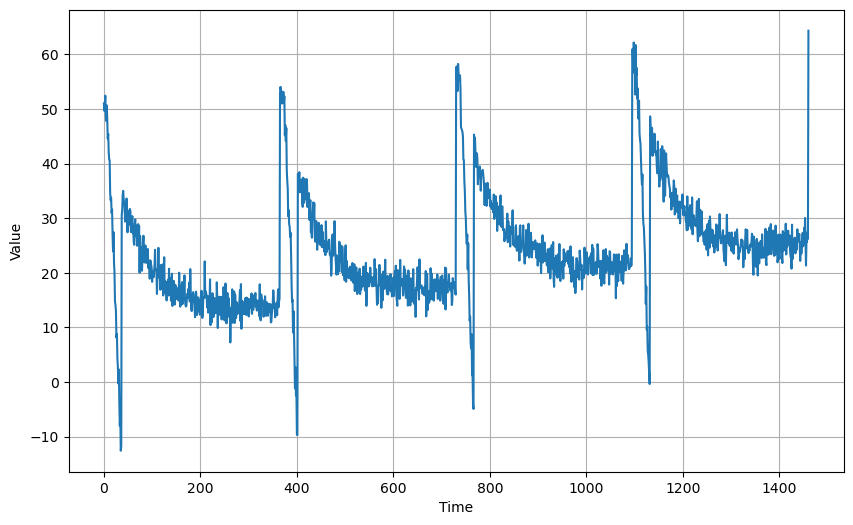

In [4]:
# The time dimension or the x-coordinate of the time series
TIME = np.arange(4 * 365 + 1, dtype="float32")

# Initial series is just a straight line with a y-intercept
y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

# Adding seasonality
amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

# Adding some noise
noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

# Plot the series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

This is a good time to also define some useful global variables. 

In [5]:
# Define time step to split the series
SPLIT_TIME = 1100

# Define the window size for forecasting later on
WINDOW_SIZE = 50

### Exercise 1: train_val_split

Now that you have the time series, let's split it so you can start forecasting.

Complete the `train_val_split` function below which receives the `time` (x coordinate) and `series` (y coordinate) data. Notice that this value defaults to 1100 since this is an appropriate step to split the series into training and validation:

In [6]:
# GRADED FUNCTION: train_val_split
def train_val_split(time, series, time_step=SPLIT_TIME):

    ### START CODE HERE
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]
    ### END CODE HERE

    return time_train, series_train, time_valid, series_valid

The following cell creates the splits which will later be used to check the metrics of different forecasts. **These variables are **NOT** meant to be used in your solutions. Remember that globals that are safe to be used are denoted by UPPER CASE.**

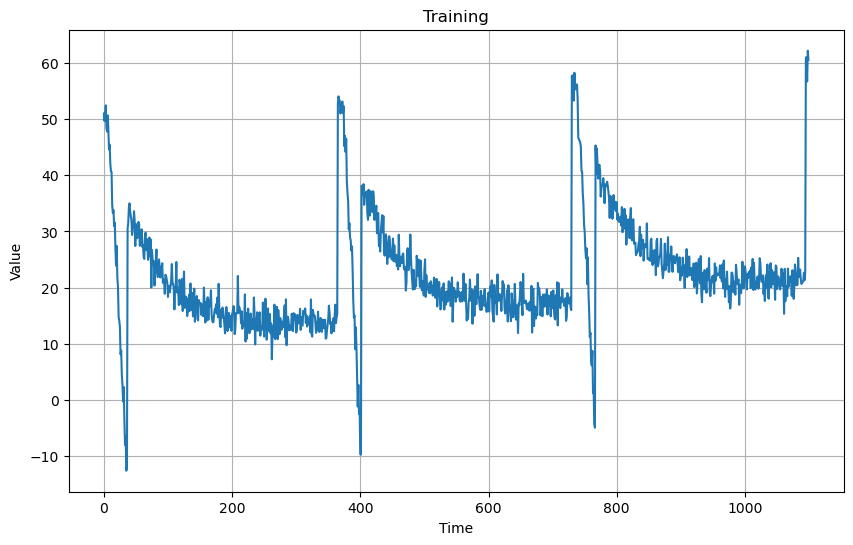

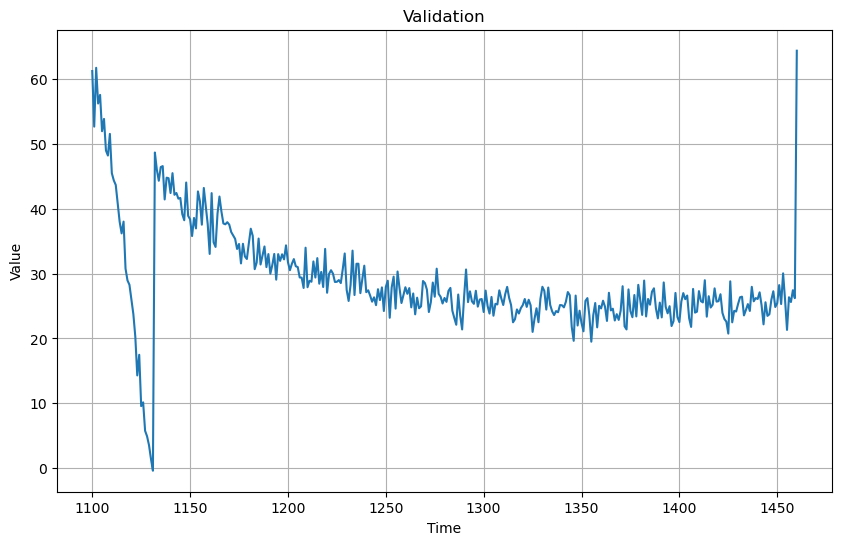

In [7]:
# Get your train and validation splits
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 6))
plot_series(time_train, series_train, title="Training")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, title="Validation")

**Expected Output:**

<table><tr><td><img src='images/train_series.png' ></td><td><img src='images/val_series.png'></td></tr></table>

In [8]:
# Test your code!
unittests.test_train_val_split(train_val_split)

 All tests passed!


## Evaluation Metrics

### Exercise 2: compute_metrics

Now that you have successfully split the data into training and validation sets you will need a way of knowing how good your forecasts are. For this complete the `compute_metrics` below. This function receives the true series and the forecast and returns the `mse` and the `mae` between the two curves.  You should use functions provided by [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses) to compute MSE and MAE errors.

**Notice that this function does not receive any time (x coordinate) data since it assumes that both series will have the same values for the x coordinate**

In [9]:
# GRADED FUNCTION: compute_metrics
def compute_metrics(true_series, forecast):
    
    ### START CODE HERE
    mse = np.square(forecast - true_series).mean()
    mae = np.abs(forecast - true_series).mean()
    ### END CODE HERE

    return mse, mae

In [10]:
# Try out your function

# Define some dummy series for testing
zeros = np.zeros(5)
ones = np.ones(5)

mse, mae = compute_metrics(zeros, ones)
print(f"mse: {mse}, mae: {mae} for series of zeros and prediction of ones\n")

mse, mae = compute_metrics(ones, ones)
print(f"mse: {mse}, mae: {mae} for series of ones and prediction of ones")

mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones


**Expected Output:**

```
mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones
```

In [11]:
# Test your code!
unittests.test_compute_metrics(compute_metrics)

 All tests passed!


# Forecasting

Now that you have a way of measuring the performance of your forecasts it is time to actually start doing some forecasts. Your goal is to predict the values in the validation set.

Let's start easy by using a naive forecast.

## Naive Forecast

### Exercise 3: naive_forecast

Define the `naive_forecast` variable below. Remember that the naive forecast simply takes the last value to predict the next one. This means that the forecast series should be identical to the validation series but delayed one time step. 

**Hints:**

- Use the whole `SERIES` (training and validation) and the `SPLIT_TIME` to compute this one

- The resulting series should leave out the last element since this element does not exists in the validation set and you will not be able to compute the evaluation metrics if this element is kept

In [12]:
### START CODE HERE
naive_forecast = SERIES[SPLIT_TIME-1:len(SERIES)-1]
### END CODE HERE

In [13]:
# Look into naive_forecast
print(f"validation series has shape: {series_valid.shape}\n")
print(f"naive forecast has shape: {naive_forecast.shape}\n")
print(f"comparable with validation series: {series_valid.shape == naive_forecast.shape}")

validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True
```

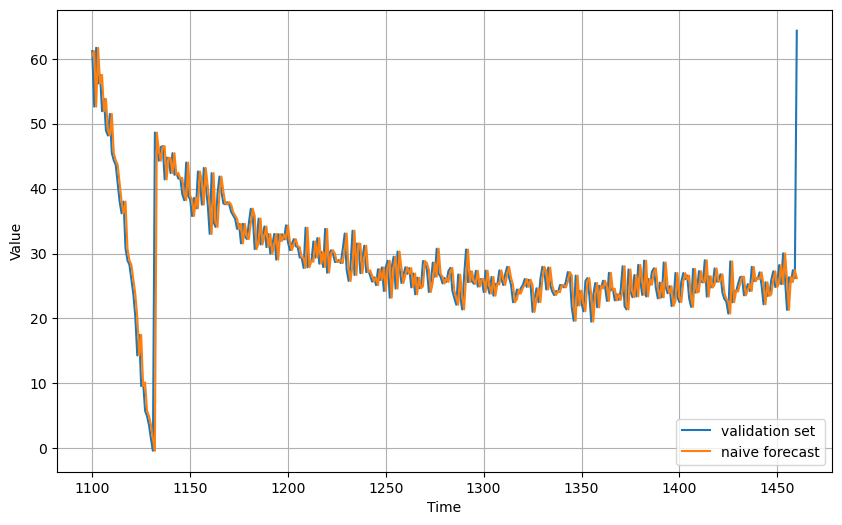

In [14]:
# Plot the validation data and the naive forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, label="validation set")
plot_series(time_valid, naive_forecast, label="naive forecast")

**Expected Output:**

<div>
<img src="images/naive.png" width="650"/>
</div>

Let's zoom in on the end of the validation period:

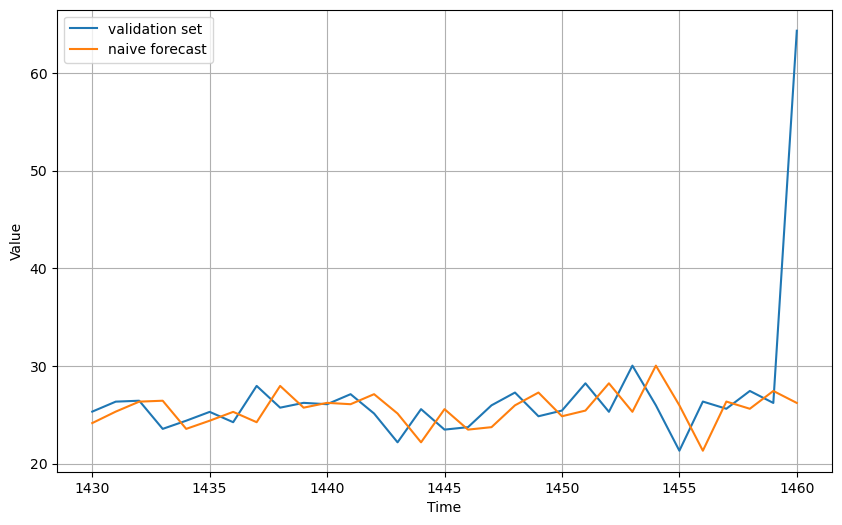

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, start=330, end=361, label="validation set")
plot_series(time_valid, naive_forecast, start=330, end=361, label="naive forecast")

**Expected Output:**

<div>
<img src="images/naive_zoom.png" width="650"/>
</div>

**You should see that the naive forecast lags 1 step behind the time series and that both series end on the same time step.**

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [16]:
mse, mae = compute_metrics(series_valid, naive_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for naive forecast")

mse: 19.58, mae: 2.60 for naive forecast


**Expected Output:**

```
mse: 19.58, mae: 2.60 for naive forecast
```

In [17]:
# Test your code!
unittests.test_naive_forecast(naive_forecast)

 All tests passed!


That's our baseline, now let's try a moving average.

## Moving Average

### Exercise 4: moving_average_forecast

Complete the `moving_average_forecast` function below. This function receives a `series` and a `window_size` and computes the moving average forecast for every point after the initial `window_size` values.

**This function should receive the complete `SERIES` and, just for this exercise, you will get the prediction for all the `SERIES`. The returned prediction will then be sliced to match the validation period, so your function doesn't need to account for matching the series to the validation period.**

In [18]:
# GRADED FUNCTION: moving_average_forecast
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""
    
    forecast = []
    
    ### START CODE HERE  
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
        
    # Conver to a numpy array
    np_forecast = np.array(forecast)
    
    ### END CODE HERE
    
    return np_forecast

You cannot compute the moving average for the first `window_size` values since there aren't enough values to compute the desired average. So if you use the whole `SERIES` and a `window_size` of 50 your function should return a series with the number of elements equal to:

```python
len(SERIES) - 50
````

In [19]:
print(f"Whole SERIES has {len(SERIES)} elements so the moving average forecast should have {len(SERIES)-50} elements")

Whole SERIES has 1461 elements so the moving average forecast should have 1411 elements


In [20]:
# Try out your function
moving_avg = moving_average_forecast(SERIES, window_size=WINDOW_SIZE)
print(f"moving average forecast with whole SERIES has shape: {moving_avg.shape}\n")

# Slice it so it matches the validation period
moving_avg = moving_avg[1100 - WINDOW_SIZE:]
print(f"moving average forecast after slicing has shape: {moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == moving_avg.shape}")

moving average forecast with whole SERIES has shape: (1411,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
moving average forecast with whole SERIES has shape: (1411,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True
```

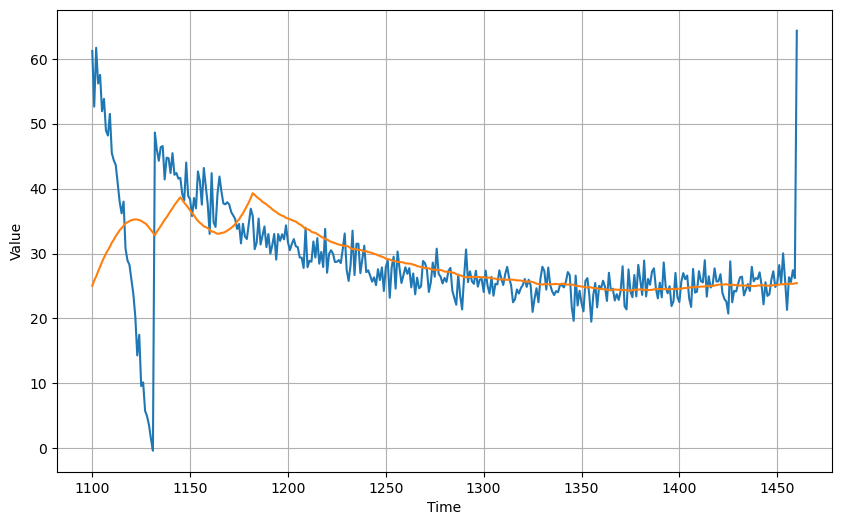

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

**Expected output:**
<div>
<img src="images/moving_avg.png" width="650"/>
</div>

In [22]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, moving_avg)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")

mse: 56.80, mae: 4.12 for moving average forecast


**Expected Output:**

```
mse: 56.80, mae: 4.12 for moving average forecast
```

In [23]:
# Test your code!
unittests.test_moving_average_forecast(moving_average_forecast)

 All tests passed!


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differentiation. 

## Differencing

### Exercise 5: diff_series

Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

Define the `diff_series` and `diff_time` variables below to achieve this. Notice that `diff_time` is the values of the x-coordinate for `diff_series`.

In [24]:
### START CODE HERE
diff_series = np.array([SERIES[i] - SERIES[i-365] for i in range(365, len(SERIES))])
diff_time = np.array([x for x in range(365, len(SERIES))])
### END CODE HERE

In [25]:
print(f"Whole SERIES has {len(SERIES)} elements so the differencing should have {len(SERIES)-365} elements\n")
print(f"diff series has shape: {diff_series.shape}\n")
print(f"x-coordinate of diff series has shape: {diff_time.shape}\n")

Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)



**Expected Output:**
```
Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)
```

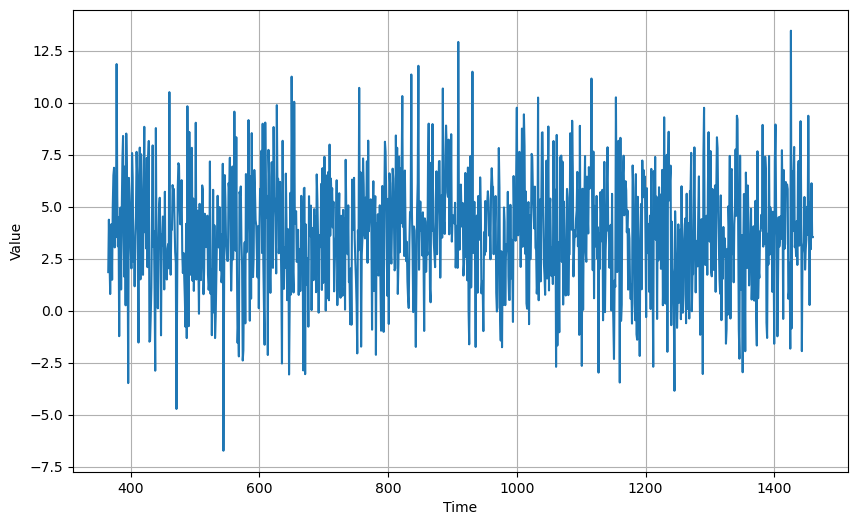

In [26]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)

**Expected output:**

<div>
<img src="images/diff.png" width="650"/>
</div>

In [27]:
# Test your code!
unittests.test_diff_series(diff_series)

 All tests passed!


### Exercise 6: diff_moving_average

Great, the trend and seasonality seem to be gone, so now we can use the moving average.

Define the `diff_moving_avg` variable. 

**Notice that the `WINDOW_SIZE` has already being defined and that you will need to perform the correct slicing for the series to match the validation period.**

In [28]:
### START CODE HERE

# Apply the moving avg to diff series
diff_moving_avg = moving_average_forecast(diff_series, 50)

print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}\n")

# Perform the correct slicing
diff_moving_avg = diff_moving_avg[SPLIT_TIME-365-50:]

### END CODE HERE

moving average forecast with diff series has shape: (1046,)



In [29]:
print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg.shape}")

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True


**Expected Output:**
```
moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True
```

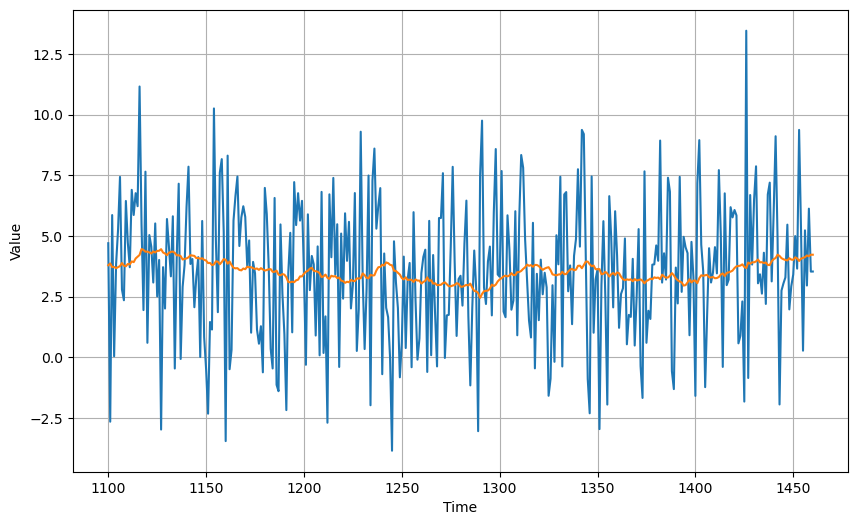

In [30]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)

**Expected output:**

<div>
<img src="images/diff_moving.png" width="650"/>
</div>

In [31]:
# Test your code!
unittests.test_diff_moving_avg(diff_moving_avg)

 All tests passed!


### Exercise 7: diff_moving_avg_plus_past

Now let's bring back the trend and seasonality by adding the past values from t – 365. For each value you want to forecast, you will be adding the exact same point, but from the previous cycle in the original time series. 

In [32]:
### START CODE HERE

# Slice the whole SERIES to get the past values
past_series = SERIES[SPLIT_TIME-365:SPLIT_TIME-4]

print(f"past series has shape: {past_series.shape}\n")


# Add the past to the moving average of diff series
diff_moving_avg_plus_past = past_series + diff_moving_avg

### END CODE HERE

past series has shape: (361,)



In [33]:
print(f"past series has shape: {past_series.shape}\n")
print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_past.shape}")

past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True
```

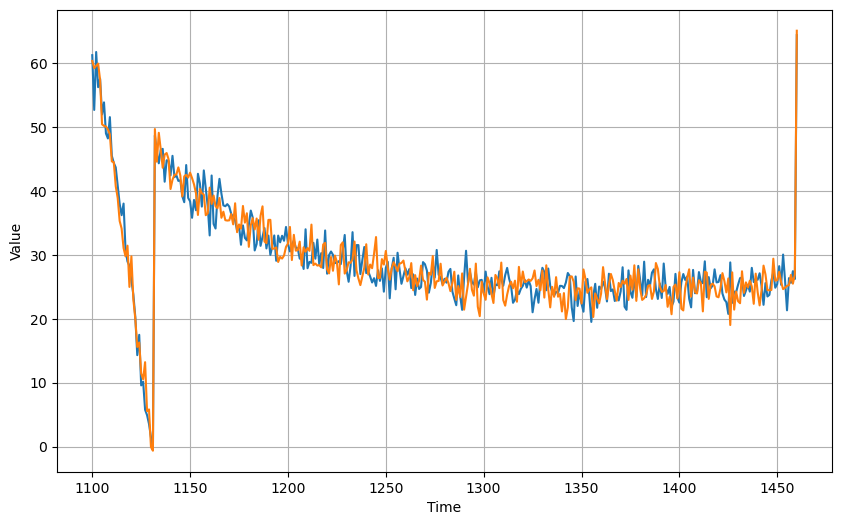

In [34]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

**Expected output:**

<div>
<img src="images/plus_past.png" width="650"/>
</div>

In [35]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

mse: 8.50, mae: 2.33 for moving average plus past forecast


**Expected Output:**

```
mse: 8.50, mae: 2.33 for moving average plus past forecast
```

In [36]:
# Test your code!
unittests.test_diff_moving_avg_plus_past(diff_moving_avg_plus_past)

 All tests passed!


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. 

### Exercise 8: smooth_past_series

Let's use a moving averaging on **past** values to remove some of the noise. Use a `window_size=11` for this smoothing.

In [37]:
### START CODE HERE

# Perform the correct split of SERIES
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME-365-5:SPLIT_TIME+1], 10)

print(f"smooth past series has shape: {smooth_past_series.shape}\n")

# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

### END CODE HERE

smooth past series has shape: (361,)



In [38]:
print(f"smooth past series has shape: {smooth_past_series.shape}\n")

smooth past series has shape: (361,)



In [39]:
# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_smooth_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_smooth_past.shape}")

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True
```

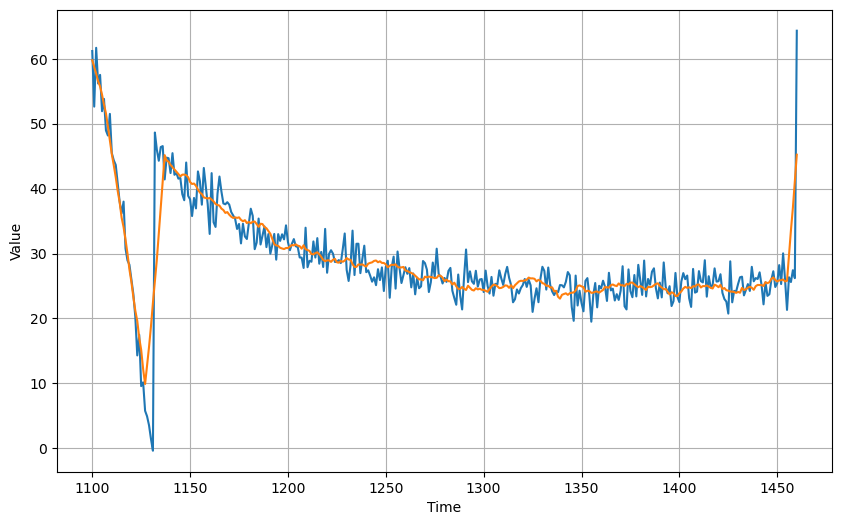

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)

**Expected output:**

<div>
<img src="images/plus_smooth.png" width="650"/>
</div>

In [41]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_smooth_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")

mse: 12.53, mae: 2.20 for moving average plus smooth past forecast


**Expected Output:**

```
mse: 13.57, mae: 2.26 for moving average plus smooth past forecast
```

In [42]:
# Test your code!
unittests.test_smooth_past_series(smooth_past_series)

Failed test case: diff_moving_avg_plus_smooth_past has incorrect first 5 values.
Expected: [55.13228  54.10422  53.275375 52.182724 51.436935]
Got: [55.97799  54.876335 53.986572 52.818268 52.073677]

Failed test case: diff_moving_avg_plus_smooth_past has incorrect last 5 values.
Expected: [28.81515  31.856792 35.53977  39.16417  42.837337]
Got: [25.592197 29.374119 32.877644 37.027885 41.0016  ]




**Congratulations on finishing this week's assignment!**

You have successfully implemented functions for time series splitting and evaluation while also learning how to deal with time series data and how to code forecasting methods!

**Keep it up!**